# Подготовка данных

Грузим библиотеки:

In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split

Я специально сделал cases.csv - это очищенный датасет, в котором я:
- соединил короткое и длинное описание в одно поле;
- удалил все незначимые столбцы;
- привел все в lowercase;
- оставил только русские символы и основные знаки препинания.
Все манипуляции с данными делаю в Pandas DataFrame.

In [2]:
path = '../hot_line'

In [3]:
df = pd.read_csv(path+'/cases.csv', encoding = 'utf-8')

In [ ]:
df = df.drop(columns='Unnamed: 0')

In [6]:
df.head()

,Text,Label
0,проблемы с векторами в контакт центр проблемы ...,2.0
1,не отправляются письма при отправки писем у по...,1.0
2,не отвечает на запросы коллеги добрый день н...,2.0
3,томск нет доступа в томске нет доступа к ресур...,2.0
4,в кратчайшие сроки восстановить резервную базу...,5.0


In [7]:
df.shape

(7631, 2)

Смотрим, сколько у нас кейсов для каждой метки

In [8]:
df.groupby('Label').count()

,Text
Label,
1.0,1385
2.0,1641
3.0,2937
5.0,1668


Разбиваем все данные на тренировочные и тестовые в пропорции 90/10, стратифицируя по меткам (чтобы сохранять пропорции меток между тестовым и тренировочным сетами)

In [10]:
df_train=pd.DataFrame(columns=['Text', 'Label'])
df_test=pd.DataFrame(columns=['Text', 'Label'])

In [11]:
df_train['Text'], df_test['Text'], df_train['Label'], df_test['Label'] = train_test_split(df['Text'], df['Label'], stratify=df['Label'], test_size=0.1)

Трансформируем метки в Integer, чтобы получить категорийную переменную, а не непрерывную.

In [12]:
df_train['Label'] = pd.to_numeric(df_train['Label'], downcast='integer')
df_test['Label'] = pd.to_numeric(df_test['Label'], downcast='integer')

Смотрим что получилось

In [13]:
df_train.groupby('Label').count()

,Text
Label,
1,1246
2,1477
3,2643
5,1501


In [14]:
df_test.groupby('Label').count()

,Text
Label,
1,139
2,164
3,294
5,167


Записываем в отдельные csv на всякий случай

In [15]:
df_train.to_csv(path+'/cases_train.csv', encoding = 'utf-8')

In [16]:
df_test.to_csv(path+'/cases_test.csv', encoding = 'utf-8')

# Обучение Language Model

Первая задача - получить языковую модель, на основе общедоступной предобученной, которую мы доучиваем на нашем датасете. Задача языковой модели - предсказывать следующее слово в последовательности. Далее обученную языковую модель будем использовать для задачи классификации.

In [17]:
tokenizer=Tokenizer(lang='xx')

Загружаем данные для дообучения языковой модели

In [18]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, tokenizer=tokenizer, bs=32, csv_name = 'cases_train.csv')

In [19]:
data_lm.save('data_lm')

Грузим предобученные веса языковой модели Russian ULMFit, взято отсюда:
https://github.com/mamamot/Russian-ULMFit

In [20]:
weights_pretrained = 'lm_5_ep_lr2-3_5_stlr'
itos_pretrained = 'itos'
pretained_data = (weights_pretrained, itos_pretrained)

Создаем learner, который будем обучать.
Параметр config - костыли из-за того, что новые версии fast.ai не поддерживают обратную совместимость с весами модели, сохраненными в более старых версиях.

In [21]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=pretained_data, drop_mult=0.3)
learn_lm.freeze()

Определяем оптимальный learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


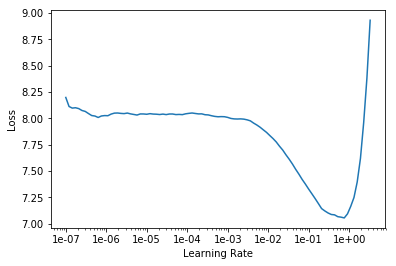

In [22]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_start=0)

Обучаем модель на 3 эпохах.

In [23]:
learn_lm.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.449820,4.616520,0.314103,00:16
1,4.883268,4.214985,0.352232,00:16
2,3.907723,3.972322,0.379363,00:16


Размораживаем все слои модели для обучения и дообучаем на 10 эпохах

In [24]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.201664,3.783950,0.398843,00:21
1,3.017545,3.696533,0.410856,00:21
2,2.901162,3.698295,0.412764,00:21
3,2.593064,3.640842,0.433218,00:21
4,2.157360,3.638989,0.451684,00:21
5,1.655798,3.724633,0.469683,00:21
6,1.148081,3.890813,0.482021,00:21
7,0.761899,4.024605,0.489489,00:21
8,0.548614,4.065925,0.494014,00:21
9,0.467496,4.064565,0.495333,00:21


Записываем веса как всей модели, так и encoder, который понадобится в классификации

In [25]:
learn_lm.save('lm_fine_tuned')
learn_lm.save_encoder('ft_enc')

Пробуем нашу языковую модель в деле. Просим ее придумать 10 слов после фразы "Возникла проблема". Видим что направление мысли у модели верное :-)

In [26]:
learn_lm.predict("Возникла проблема", n_words=10)

'Возникла проблема со связью при попытке зайти на портал доступен через форму'

# Обучение классификатора

Загружаем данные для обучения классификатора. При этом будем использовать 10% данных для валидации случайным образом (параметр valid_pct). Batch Size = 16. Больше у меня не лезет в GPU.

In [27]:
data_clas = TextClasDataBunch.from_csv(path, vocab=data_lm.train_ds.vocab, bs=16, csv_name='cases_train.csv', valid_pct=0.1, text_cols=1, label_cols=2, tokenizer=tokenizer)

Заглянем внутрь, посмотрим как выглядят данные

In [28]:
data_clas.show_batch()

text,target
xxbos контроллерный модуль здравствуйте сервер г архангельск ул федота шубина д государственное автономное учреждение архангельской области управление информационно коммуникационных технологий архангельской области илья при сдаче работ по государственному контракту исполнитель не передал сертификат на техническую поддержку сервера х года х указанный в акте о приёмке выполненных работ предоставляется ли данный сертификат в бумажном виде возможно ли его получить повторно срок действия технической поддержки на данный сервер условия предоставления технической поддержки,1
xxbos оптический коммутатор здравствуйте сервер г архангельск ул федота шубина д государственное автономное учреждение архангельской области управление информационно коммуникационных технологий архангельской области илья при сдаче работ по государственному контракту исполнитель не передал сертификат на техническую поддержку сервера х года х указанный в акте о приёмке выполненных работ предоставляется ли данный сертификат в бумажном виде возможно ли его получить повторно срок действия технической поддержки на данный сервер условия предоставления технической поддержки,1
xxbos настройки канала интернет в офисе марта офис альянс в калининграде планирует xxunk настройки канала интернет в офисе соответственно также xxunk прошу связаться с xxunk xxunk ее контакты ниже и xxunk с ней время работ перенастроить xxunk оборудование сейчас на новые данные спасибо с уважениемвалерий гарейшин руководительгруппы сопровождения сетевого оборудованиядепартамента сопровождения инфраструктурных технологий и пользователей оао ск альянсозерковская наб д москва россия тел доб факс моб на запланирован переезд сотрудника,5
xxbos фсб xxunk xxunk xxunk в xxunk мы xxunk оборудование по данному проекту у партнера который проводит пнр возникли следующие вопросы помогите пожалуйста с решением нескольких вопросов при попытке скачать лицензию с сайта выдает ошибку к сожалению вы не имеете доступа к поскольку вы не xxunk для этого приложения в если вас интересует причина по которой это сделано обратитесь к своему xxunk если это поможет мы можем вернуть вас на,1
xxbos эксплуатационная документация схд модель серийный номер г екатеринбург ул xxunk д филиал ао со еэс оду урала артур якупов прошу предоставить при наличии эксплуатационную документацию для и схожую например с у руководства по эксплуатации которые пришли в комплекте с оборудованием содержат общие справочные сведения например там указано что порт предназначен для выполнения начальной инициализации оборудования однако информации где брать образ для создания нет на сайте кроме информационной брошюры также,1


Создаем learner с теми же костылями с помощью config

In [33]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150
learn = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.3)

Ищем оптимальный learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


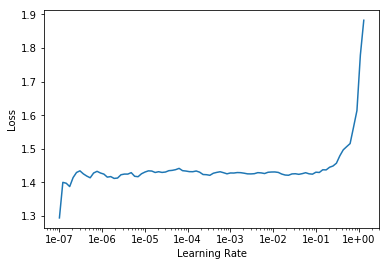

In [34]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

Обучаем модель постепенно размораживая слои и дообучая ее на все большем количестве эпох.

In [35]:
learn.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.333739,1.298599,0.397380,00:29
1,1.294202,1.254996,0.404658,00:33


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/2., 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.170921,3.446936,0.179039,00:33
1,1.097748,1.240123,0.458515,00:33
2,0.993509,2.064039,0.420670,00:34
3,0.926528,0.790019,0.689956,00:32
4,0.924841,0.773171,0.695779,00:34


In [37]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(4e-3/100, 4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.844706,0.784311,0.672489,00:58
1,0.826970,0.705876,0.703057,01:01
2,0.752631,0.665131,0.740902,00:56
3,0.637863,0.606488,0.772926,01:07
4,0.587171,0.605899,0.772926,00:55
5,0.505802,0.579676,0.784571,00:55
6,0.422291,0.586438,0.788937,01:04
7,0.331315,0.574251,0.790393,00:58
8,0.335394,0.578173,0.788937,01:01
9,0.311984,0.581683,0.787482,01:00


Получили 78.7% точности на валидации. Пробуем предсказать на фразе, получаем вторую категорию (похоже верно)

In [38]:
learn.predict('со вчерашнего дня недоступен сервер')

(Category 2,
 tensor(1),
 tensor([2.4434e-04, 9.7472e-01, 1.7388e-03, 2.3298e-02]))

Записываем веса модели:

In [52]:
learn.save('hotline-0.787')

# Тест эффективности модели на тестовых данных

Загружаем тестовые данные из файла cases_test, чтобы проверить эффективность модели на нем.

In [39]:
data_test_clas = TextClasDataBunch.from_csv(path, vocab=data_lm.train_ds.vocab, bs=16, csv_name='cases_test.csv', text_cols=1, label_cols=2, tokenizer=tokenizer)

Смотрим пример тестовых данных

In [40]:
data_test_clas.show_batch()

text,target
xxbos производительность через на здравствуйте наименование организации xxunk контактное лицо александр xxunk телефон доб контактный xxunk кейс в по производительности по на получили ответ что требуется рекомендация вендора схд по настройке его на низкая производительность наблюдается как в xxunk от вендора серверов так и на xxunk xxunk рекомендации выполнены при этом с xxunk по тому же скорость xxunk ввиду этого прошу предоставить xxunk настройку xxunk для схд привожу запрос от,1
xxbos прошу выполнить следующие настройки в стратегиях добрый день приоритет среднийподсистема прошу выполнить следующие настройки в стратегиях в стратегии исключить из проверки наличия зарегистрированных агентов со скиллом и проверять только наличие агентов со скиллом и со скиллом и и из распределения исключить скилл в стратегии исключить из проверки скилл и и убрать распределение на скилл и оставить распределение только на в стратегии исключить из проверки скилл и и убрать распределение,5
xxbos циан вторичка привет зарегистрируйте заявку по xxunk инициатор лака алексей исполнитель дмитрий швыдко с уважением виктория нестероваооо стэп лоджиктел доб доб моб факс е лака алексей александрович нестерова виктория сергеевна циан xxunk добрый день нам необходимо подключить еще один номер схема звонка во вложении с уважением лака алексейзаместитель руководителя дитао дон строй инвест моб доб лыжников андрей владимирович лака алексей александрович глова роман андреевич намашко ирина анатольевна михайличенко евгения,3
xxbos консультация по иван доброго времени суток xxunk железо собственно в процессе его эксплуатации возникают некоторые вопросы сейчас закончились xxunk о двум проблемам остались только xxunk не могли бы проконсультировать проблема xxunk в питере на xxunk непонятно с чего туннели перестали xxunk xxunk друг с другом проблема очень xxunk на ту что была на xxunk но после дня xxunk с провайдером пришли к тому что порты для xxunk туннелей не,1
xxbos не работает в курске добрый день примите пожалуйста заявку на восстановление канала с xxunk с уважениемвалерий гарейшин xxunk николай алексеевич горячая линия ск альянс проблемы с xxunk день xxunk недавно пропало соединение из за чего не можем работать с серверами головного офиса сам интернет работает корректно перезапуск оборудования не помог на индикатор горит xxunk цветом прошу xxunk заявку на проверку сетевого оборудования которое находится в филиале спасибо с уважением,2


Cоздаем отдельный learner, куда загружаем тестовые данные

In [47]:
learn_test = learn

In [48]:
learn_test.data = data_test_clas

Проверяем точность и строим confusion matrix

In [49]:
interp = ClassificationInterpretation.from_learner(learn_test)

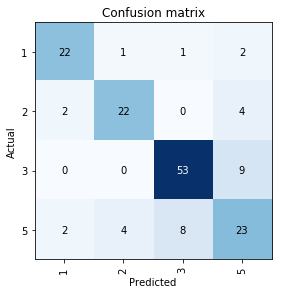

In [50]:
interp.plot_confusion_matrix()

In [51]:
print(120/153)

0.7843137254901961


На тестовом датасете получили точность 78.4%.
Видим, что наибольшая путаница у модели возникает между метками 3 и 5. Возможно надо еще раз проверить качество разметки и вообще определения, что в какой класс должно попадать.